In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Summary
both vanilla and mlp have big problems in trying to get anywhere near the target. Movement in mean (during run) is very similar.

In [2]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
    for c in cfgs_flat:
        c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
        c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
    configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../runs

two-dim/


In [4]:
rundir = basedir + "runs/two-dim/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

<ipython-input-2-23f8c11618f9>:52: UserWarning: Detected NaNs in dataframe. 1 / 64 rows include at least one NaN or inf. Dropping all rows with nonfinite values.
  warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")


In [5]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", "svgd_steps", "encoder_layers", "ksd_steps", "train", "lambda_reg"]
f = frame[relevant]
# f

# Hyperparameter comparison

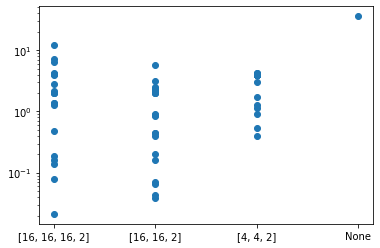

In [6]:
plt.scatter(f.encoder_layers, f.se_var)
plt.yscale("log")

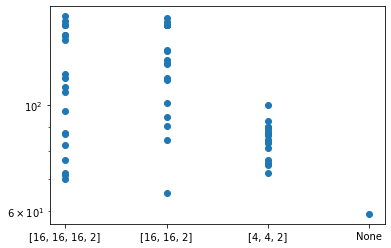

In [7]:
plt.scatter(f.encoder_layers, f.se_mean)
plt.yscale("log")

# Rundata

In [9]:
sweep_metaconfigs[0]["svgd"]["target_args"]

[[array([5.48813504, 7.15189366]),
  array([[2.64088548, 2.42920175],
         [2.42920175, 2.38665038]])]]

In [10]:
rundata[0].keys()

odict_keys(['Interrupted because of NaN', 'encoder_params', 'ksd_after_svgd_update', 'ksd_after_svgd_update_val', 'ksd_before_kernel_update', 'ksd_before_kernel_update_val', 'mean', 'particles', 'square_errors', 'training_mean', 'training_var', 'update_to_weight_ratio', 'validation_mean', 'validation_var', 'var'])

In [11]:
f[f.train == False]

,se_mean,se_var,ksd,emd,lr_ksd,svgd_steps,encoder_layers,ksd_steps,train,lambda_reg
12,59.172127,35.913139,0.887483,11.032565,NaN,1,None,NaN,False,NaN


In [12]:
ind = 2
f.iloc[ind]

se_mean               114.106
se_var               0.399323
ksd                   7.41988
emd                   15.1555
lr_ksd               0.316228
svgd_steps                  1
encoder_layers    [16, 16, 2]
ksd_steps                   5
train                    True
lambda_reg                  1
Name: 2, dtype: object

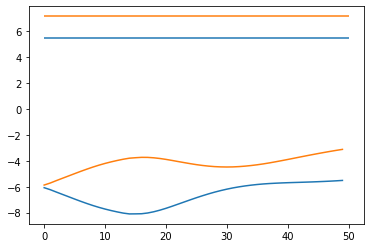

In [20]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 50, colors=colorcycle)

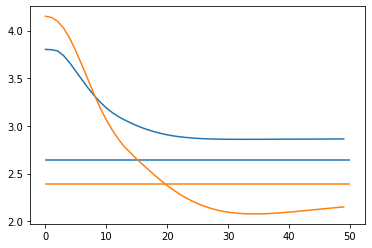

In [21]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 50, colors=colorcycle)

### KSD

In [15]:
n_iter = 200

In [16]:
ind = 2

In [17]:
frame.iloc[2]

emd                                                                     15.1555
ksd                                                                     7.41988
se_mean                                                                 114.106
se_var                                                                 0.399323
decoder_layers                                                       [2, 16, 2]
encoder_layers                                                      [16, 16, 2]
kernel                                                                      ard
n_particles                                                                5000
n_subsamples                                                                200
optimizer_svgd                                                          Adagrad
lr_svgd                                                                       1
subsample_with_replacement                                                False
target                                  

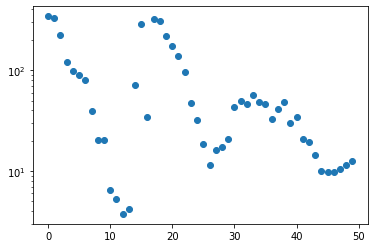

In [18]:
plt.plot(onp.array(rundata[ind]["ksd_after_svgd_update"]), "o", label="KSD after svgd update")
plt.yscale("log")

KeyError: 'ksd_after_kernel_update'

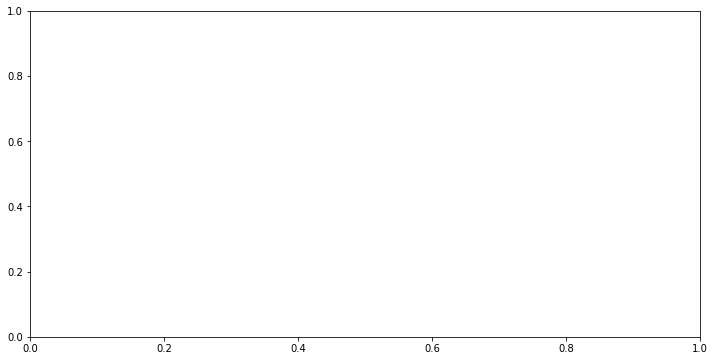

In [19]:
fig, ax = plt.subplots(figsize=[12, 6])
# idx = onp.arange(len(onp.array(rundata[ind]["ksd_after_kernel_update"])))
ax.plot(onp.array(rundata[ind]["ksd_after_kernel_update"]), "o", label="KSD after kernel update")

# ax.legend()
ax.set_yscale("log")

In [ ]:
f